In [53]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import asarray
from sklearn.ensemble import IsolationForest
if not 'BASE_DIR' in locals():
    BASE_DIR = os.path.abspath(os.curdir)

In [54]:
if os.path.abspath(os.curdir) == BASE_DIR:
    os.chdir('../')

dirname = os.path.abspath(os.curdir) + r'\data'
df = pd.read_csv(path.join(os.sep, dirname, 'Annual rainfall in Nottingham castle 1867  1939.csv'))
df = df.drop('Unnamed: 0', axis=1)
df.head()

,x
0,29.90
1,25.33
2,27.75
3,17.93
4,26.83


In [55]:
def Fuller(name:str, df:pd.DataFrame):
    alpha = 0.05
    if hasattr(df, 'columns'):
        df = df[df.columns[0]]
    print(f'Тест Дики-Фуллера ряда {name} :')
    # определяем результат значения теста из библиотеки с учетом
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")
Fuller('Rainfall', df)

Тест Дики-Фуллера ряда Rainfall :
Test Statistic                 -3.383976
p-value                         0.011517
#Lags Used                      2.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


Предсказание временного ряда

In [56]:
n_vars = 1 if type(df) is list else df.shape[1]
cols = list()
SHIFT = len(df)//8
for i in range(SHIFT, 0, -1):
    cols.append(df.shift(i))
for i in range(0, 1):
    cols.append(df.shift(-i))
# put it all together
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

In [57]:
def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [58]:
predictions = list()
size = int(len(list_for_forecast) * 0.8)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

print(f"Total points: {len(test)}")

for i in range(len(test)):
    print(f"Step {i+1}")
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

Total points: 13
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13


In [59]:
def SMAPE(y_true, y_pred):
    numerator = np.abs(y_true-y_pred)
    denumerator = (np.abs(y_true) + np.abs(y_pred))/2
    res = numerator/denumerator
    res = np.sum(res)
    res *= 100
    res /= len(y_true)
    return res
def stats(df, pred):
    print("RMSE:", np.sqrt(mean_squared_error(df, pred)))
    print("MAPE:", mean_absolute_percentage_error(df, pred))
    print("MAE:", mean_absolute_error(df, pred))
    print("R2: ", r2_score(df, pred))
    print("SMAPE", SMAPE(df, pred))

In [60]:
stats(test[:, -1], predictions)

RMSE: 3.9608705852307264
MAPE: 0.13790833550027506
MAE: 3.1826807692307657
R2:  -0.36813721199590255
SMAPE 13.013637350718671


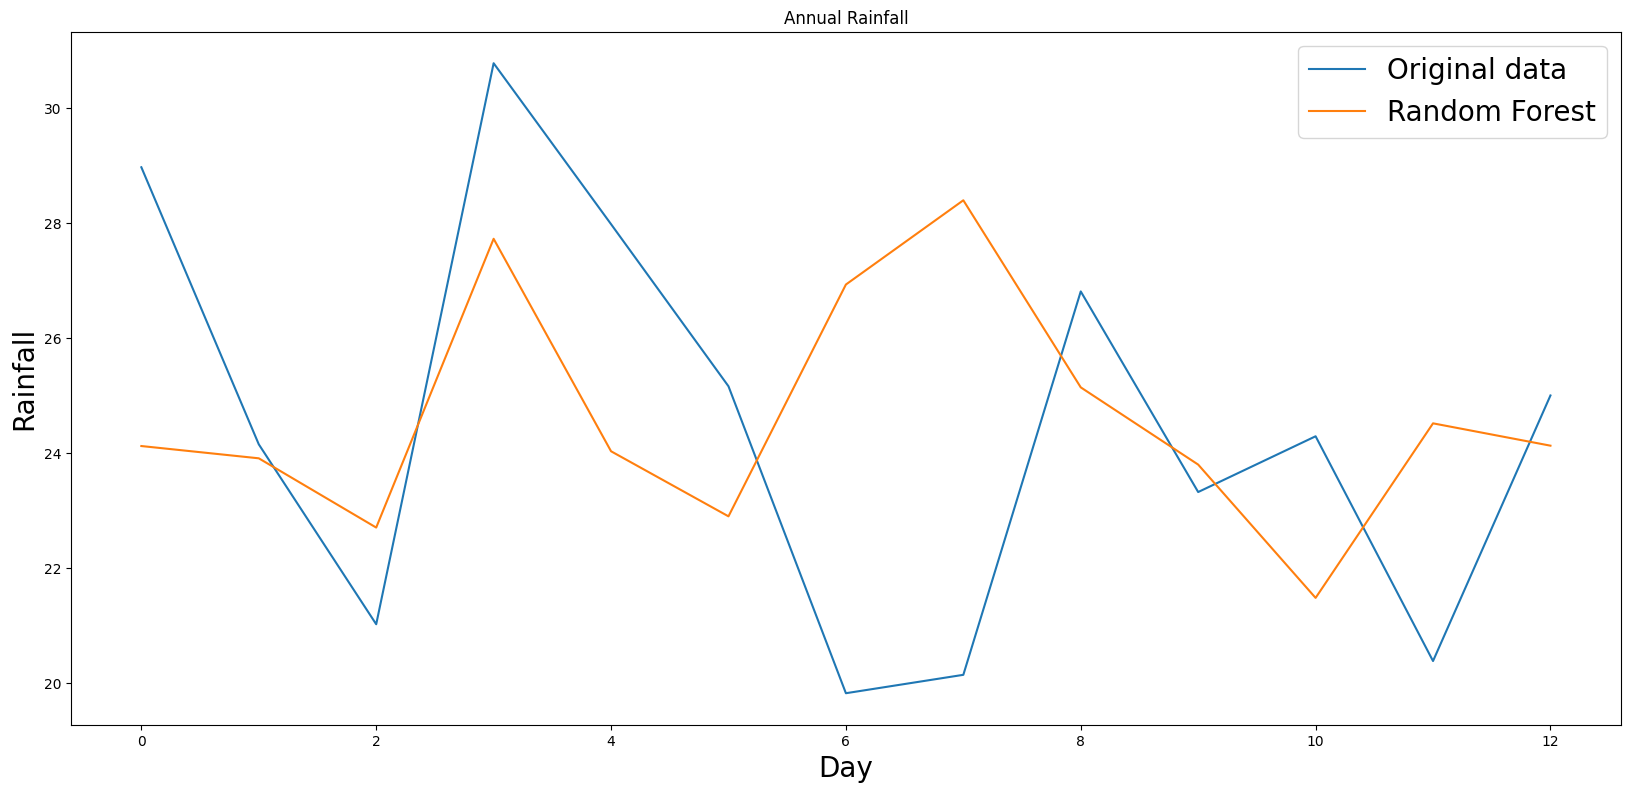

In [61]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Random Forest')
plt.legend(fontsize="20")
plt.title('Annual Rainfall')
plt.ylabel('Rainfall', fontsize="20")
plt.xlabel('Day', fontsize="20")
plt.show()

Детекция аномалий

In [62]:
model = IsolationForest(contamination=0.004)
model.fit(df[['x']])

IsolationForest(contamination=0.004)

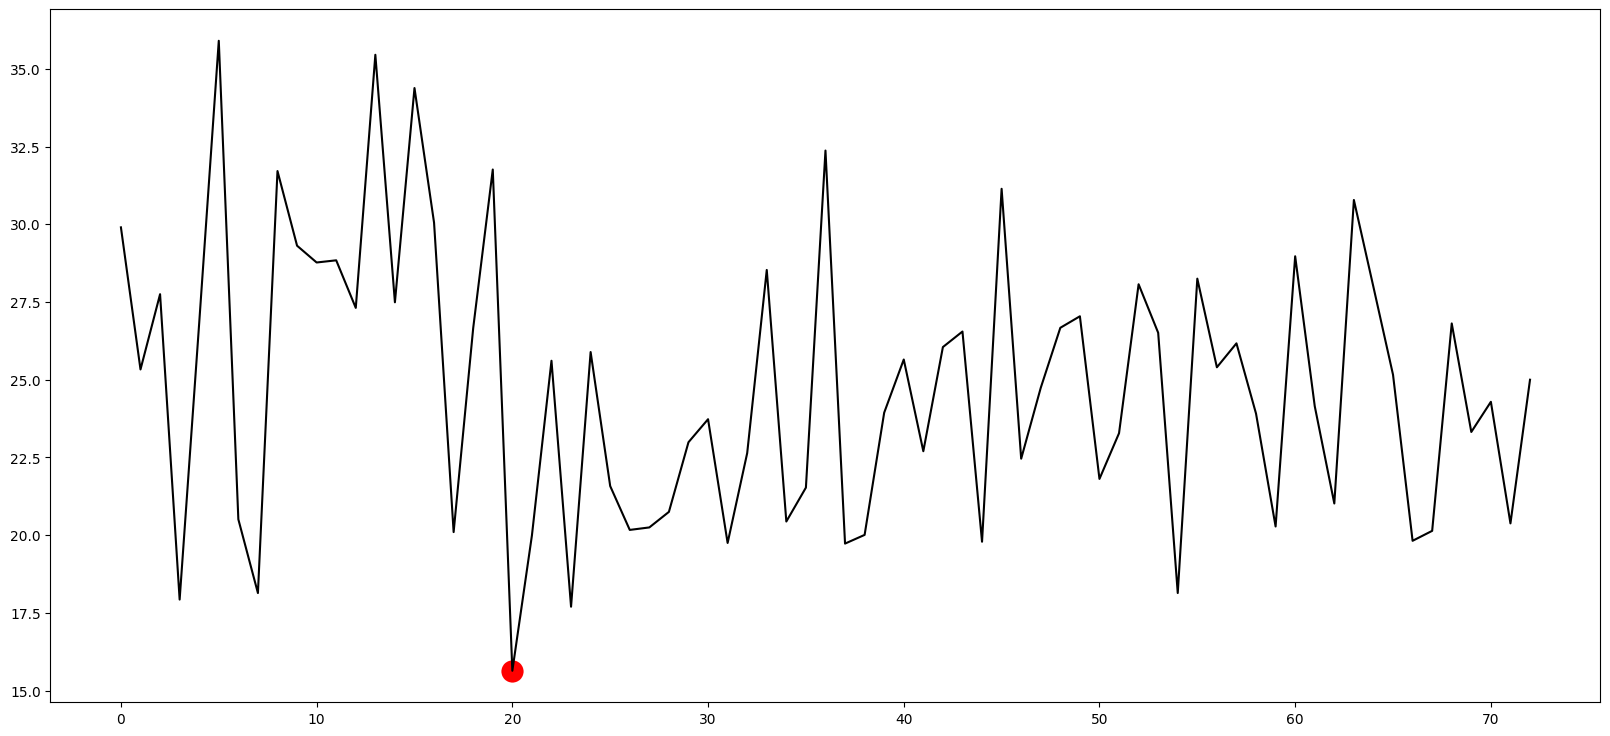

In [63]:
df['outliers'] = pd.Series(model.predict(df[['x']])).apply(lambda x: 1 if (x == -1) else 0 )
fig, ax = plt.subplots(figsize=(20,9))
ax.plot(df.index,df.x, color="black")
ax.scatter(x=df[df["outliers"]==1].index,y=df[df["outliers"]==1]["x"], color="red", linewidths=10)